# Hurricane Frequency
This notebook combines hurricane data for the Atlantic Ocean with North Atlantic ocean temperature data to visualize any possible correlations.

**Data sources**
- HURDAT2 (Storms): http://www.nhc.noaa.gov/data/#hurdat
- ERSSTv3 (Temperatures): https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v3b

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from hurricane import *

# HURDAT2 Data
More information can be found here http://www.nhc.noaa.gov/data/hurdat/hurdat2-format-atlantic.pdf. This dataset contains storm & hurricane information for each storm by year. The following script downloads the latest file and performs some transformations. The HURDAT2 data contains multiple updates per storm. A series of "agg\_" columns are added which represent max values per storm. These transformations are more than what is used to produce the final output chart.

For each storm grouped by unique code, the peak wind values are calculated by column. Storms may also vary by intensity so each storm is classified by its highest strength, regardless of when (if) it made landfall

Files are cached after the first processing and used if found.

In [2]:
# Update this file according to the latest from http://www.nhc.noaa.gov/data/hurdat/
df_hurricane = load_hurdat2_data(hurdat_file='hurdat2-1851-2016-041117.txt')

Reading cached HURDAT2


In [3]:
df_hurricane.columns

Index(['code', 'name', 'record_identifier', 'storm_status', 'latitude',
       'longitude', 'max_wind', 'min_pressure', 'wind_34kt_ne', 'wind_34kt_se',
       'wind_34kt_sw', 'wind_34kt_nw', 'wind_50kt_ne', 'wind_50kt_se',
       'wind_50kt_sw', 'wind_50kt_nw', 'wind_64kt_ne', 'wind_64kt_se',
       'wind_64kt_sw', 'wind_64kt_nw', 'datetime', 'year', 'month',
       'status_rank', 'status_cat', 'agg_max_wind', 'agg_wind_34kt_ne',
       'agg_wind_34kt_se', 'agg_wind_34kt_sw', 'agg_wind_34kt_nw',
       'agg_wind_50kt_ne', 'agg_wind_50kt_se', 'agg_wind_50kt_sw',
       'agg_wind_50kt_nw', 'agg_wind_64kt_ne', 'agg_wind_64kt_se',
       'agg_wind_64kt_sw', 'agg_wind_64kt_nw', 'agg_status_rank',
       'agg_status_cat', 'agg_min_pressure', 'agg_maxwind_34kt_tot',
       'agg_maxwind_50kt_tot', 'agg_maxwind_64kt_tot'],
      dtype='object')

In [4]:
# Uncomment if you would like the data as a CSV file
#df_hurricane.to_csv('hurricane_data.csv')

# ERSST Data
ERSST data is a global monthly dataset of sea surface temperatures. More information can be found here https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v3b. This script downloads multiple years and truncates the data to the bounding box specified below. The downloaded file contains one column per every 2 degrees of longitude and one row per 2 degrees of latitude. The data is cropped out to filter, mostly, for the North Atlantic & Gulf of Mexico. Some of the bounding box spills into the Pacific.

Files are cached as a single transformed dataframe once completed.

## Bounding Box
Bounding box is defined as a tuple of (top-left, bottom-right) data to keep. In this case the coordinates `(46,250), (0,360)` are specified. The 46 and 0 cover the Atlantic Ocean from the equator up north to around Maine. The coordinates 257, 360 transate to -102W to 0 or as far west as Colorado to the prime meridian. This box is defined to capture most of the ocean.

![Map](map.jpg)

In [5]:
'''
Specs based on: https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/ascii/Readme

latitude: -88.0, increase northward per 2 degree, to +88.0
longitude:  0.0, increase eastward per 2 degree, to 358.0

bounding_box: Defined as top-left, bottom-right
'''
bounding_box=((46, 257), (0, 360)) 
df_sst = load_ersst_data(year_start=1900, year_end=2016, bounding_box=bounding_box)

Reading cached ERSST. Warning: Parameters ignored.


In [6]:
df_sst.columns

Index([      0,       2,       4,       6,       8,      10,      12,      14,
            16,      18,      20,      22,      24,      26,      28,      30,
            32,      34,      36,      38,      40,      42,      44,      46,
        'year', 'month'],
      dtype='object')

# Get median yearly temperature
The median yearly temperature is calculated by looking at every data point for a year: Latitude x Longitude x Month = Full year measurements. A median value is calculated for the unrolled matrix, ignoring NAN. These median values are then calculated to be +/- C relative to the temperature in 1900.

In [7]:
def get_median_sst(df):
    cols = [c for c in df.columns if c not in ['year','month']]
    
    median_temps = []
    for k,v in df.groupby('year'):
        reshaped = np.reshape(v[cols].values,(-1,))
        median_temps.append((k, np.nanmedian(reshaped)))
    
    df = pd.DataFrame(median_temps, columns=['year','median_change']).set_index('year')
    df = df.sub(df.iloc[0,:])

    return df

df_sst_yearly = get_median_sst(df_sst)
df_sst_yearly.head(10)

,median_change
year,
1900,0.000
1901,-0.060
1902,-0.240
1903,-0.355
1904,-0.540
1905,-0.390
1906,-0.440
1907,-0.520
1908,-0.470


# Calculate yearly storms
Cat 4 or 5 storms are labeled as "H" while the remaining category 1-3 storms are "L". Non-hurricanes are ignored. This is joined back to the yearly change in sea temperatures.

In [8]:
def get_yearly_storms(data_hurricane, data_sst, binsize):
    
    # The preprocessing script defines hurricanes as rank 8
    df_agg = df_hurricane.copy()[(df_hurricane.agg_status_rank==8) & (df_hurricane.year>=1920)]
    
    # Label category 4 and 5 as H
    def label(x):
        if x>=4:
            return 'H'
        else:
            return 'L'
        
    df_agg['agg_status_cat'] = df_agg['agg_status_cat'].apply(label) 
    
    # Count by year the number within each H/L bucket
    df_agg = (df_agg.groupby('code')[['year','agg_status_cat']]
            .max()
            .reset_index()
            .groupby(['year','agg_status_cat'])
            .agg({'code': pd.Series.count})
            .reset_index())

    # Pivot and merge back to the temperature data
    df_agg = df_agg.pivot(index='year', columns='agg_status_cat', values='code').fillna(0)
    df_agg = df_agg.merge(data_sst, left_index=True, right_index=True).reset_index()
    
    # Calculate the # of bins needed and truncate earlier data to make even sized bins
    bins = len(df_agg) // binsize
    length = bins * binsize
    df_agg = df_agg.iloc[-length:,:]
    
    # Set each N year period into its own bin and calculate the statistics
    df_agg['bin'] = [i for i in range(bins) for _ in range(binsize)]
    df_agg = df_agg.groupby('bin').agg({'year': np.min, 'H': np.sum, 'L': np.sum, 'median_change': 'last'})
    df_agg['pct'] = df_agg['H'] / (df_agg['H'] + df_agg['L'])
    
    # Create a nice label for the graph
    start_year = df_agg.iloc[0,0]
    df_agg['label'] = ['{}-{}'.format(y, y+(binsize-1)) for y in range(start_year, start_year+length, binsize)]

    return df_agg

yearly = get_yearly_storms(df_hurricane, df_sst_yearly, 4)
yearly.head(10)
yearly.to_csv()

,year,H,L,median_change,pct,label
bin,,,,,,
0,1921,2.0,15.0,-0.460,0.117647,1921-1924
1,1925,5.0,12.0,-0.195,0.294118,1925-1928
2,1929,7.0,7.0,0.080,0.500000,1929-1932
3,1933,8.0,22.0,-0.070,0.266667,1933-1936
4,1937,2.0,15.0,0.470,0.117647,1937-1940
5,1941,4.0,17.0,0.230,0.190476,1941-1944
6,1945,4.0,15.0,-0.050,0.210526,1945-1948
7,1949,7.0,24.0,0.100,0.225806,1949-1952
8,1953,5.0,22.0,-0.100,0.185185,1953-1956


# Plot storm data
Show the two classes of storms as a stacked bar graph with a % representing the number of category 4-5 storms against all hurricanes in those years. The line chart shows the change in ocean temperature by the end of the 4 year period

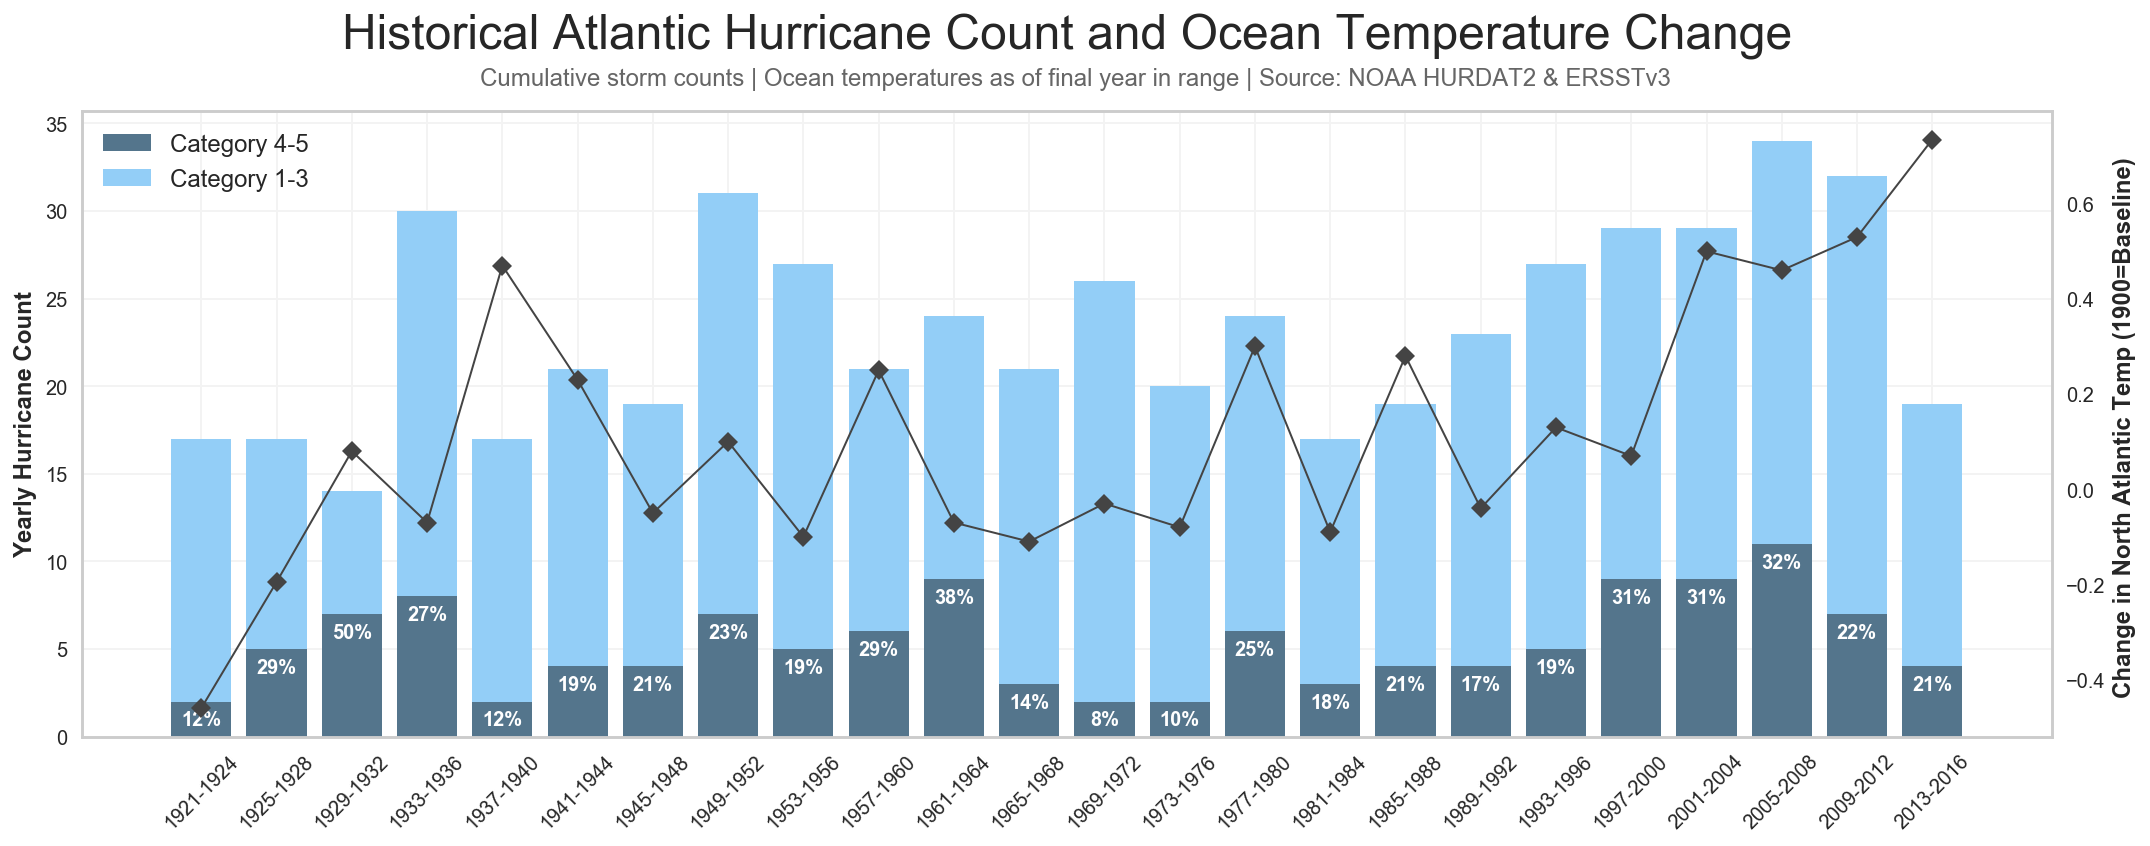

In [9]:
def plot_yearly(data):
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina' # Surfacebook has crazy high DPI
    
    sb.set_style('white', rc={'axes.edgecolor': '#CCCCCC', 'grid.color':'#F3F3F3', 'axes.grid': True})
    
    # Plot the hurricane data and give it friendly names
    ax = yearly[['H','L']].plot(kind='bar', stacked=True, figsize=(15,6), width=0.8, color=['#54758C','#93CEF7']);
    plt.xticks(range(len(data)), data['label'], rotation=45)
    ax.set_ylabel('Yearly Hurricane Count', fontsize=12, weight='bold')
    ax.set_xlabel('')
    
    # Give the legend a friendly name
    ax.legend(labels=['Category 4-5','Category 1-3'], fontsize=12)

    # Print the % for each bar but offset it down a bit. Using the max value as an anchorpoint works well
    offset = max(data['H'] + data['L']) * 0.04
    for yr in range(len(data)):
        ax.text(yr, data.iloc[yr, 1] - offset, '{:.0%}'.format(data.iloc[yr, -2]), ha='center', 
                color='white', weight='bold')
    
    # Add a second axis for the change in temperature
    ax2 = ax.twinx()
    ax2.plot(data['median_change'], color='#444444', linestyle='-', marker='D', linewidth=1)
    ax2.grid(False)
    ax2.set_ylabel('Change in North Atlantic Temp (1900=Baseline) ', fontsize=12, weight='bold')

    # Give it a nice title
    plt.title('Historical Atlantic Hurricane Count and Ocean Temperature Change', fontsize=24, y=1.08)
    plt.suptitle('Cumulative storm counts | Ocean temperatures as of final year in range | Source: NOAA HURDAT2 & ERSSTv3', 
                 y=0.91, color='#666666')
    
    plt.tight_layout()
    plt.savefig('test.jpg', dpi=300)
plot_yearly(yearly)